# IMPORT LIBRARIES AND DATA

In [ ]:
!pip install scikit-learn-extra

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 17.1 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
from scipy.special import rel_entr
from scipy.spatial.distance import mahalanobis
from numpy.linalg import inv
from sklearn_extra.cluster import KMedoids
from sklearn.metrics.pairwise import cosine_distances

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/TEXT MINING/Data/processed_dataset.csv')
embeddings = pd.read_csv('/content/drive/MyDrive/TEXT MINING/Data/cluster_complete_embeddings.csv', index_col=0)
emotion_embeddings = pd.read_csv('/content/drive/MyDrive/TEXT MINING/Data/emotional_vectors.csv', index_col=0)
synonyms = pd.read_csv('/content/drive/MyDrive/TEXT MINING/Data/cluster_top_5_similarities.csv', index_col = 0)

In [ ]:
embedding_dict = embeddings.apply(lambda row: np.array(row), axis=1).to_dict()
emotion_dict = emotion_embeddings.apply(lambda row: np.array(row), axis=1).to_dict()
synonyms_dict = synonyms.apply(lambda row: np.array(row), axis=1).to_dict()

In [ ]:
df['document_tokens'] = df['processed_text'].apply(lambda x: x.split())

In [ ]:
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(df['processed_text'])
feature_names = list(vectorizer.get_feature_names_out())

# DEFINE NEEDED FUNCTION

In [ ]:
def create_data_matrix(dict1, dict2, dict3, token_lists, tfidf_matrix, feature_names, method, debug=False):

    # Determine embedding dimension
    embedding_dim = next(iter(dict1.values())).shape[0]
    zero_vector = np.zeros(next(iter(dict2.values())).shape[0])
    max_associates = 5  # Max number of associated vectors

    # Initialize list of vectors to represent documents
    document_vectors = []

    # Iterate over documents
    for doc_idx, tokens in enumerate(token_lists):
        if debug:
            print(f"Processing document {doc_idx}")

        # Get tfidf for the current document tokens
        token_tfidf = {token: tfidf_matrix[doc_idx, feature_names.index(token)]
                       for token in tokens if token in feature_names}

        # Weighted average of Glove embeddings using TF-IDF as weights
        weighted_vectors = []
        weights = []

        # Default value of IDF for missing tokens - median of IDF train distribution
        idf_default = 9.86

        for token in tokens:
            if token in feature_names:
                # Token present in the vectorizer vocabulary, use its TF-IDF
                tfidf_value = tfidf_matrix[doc_idx, feature_names.index(token)]
            else:
                # Token missing, use default IDF to compute TF-IDF
                tfidf_value = idf_default * (tokens.count(token) / len(tokens))

            if token in dict1:
                # Calculate weighted embedding if token is in dict1
                weighted_vectors.append(dict1[token] * tfidf_value)
                weights.append(tfidf_value)

        # Compute TF-IDF mean vector
        if weighted_vectors:
            tfidf_mean_vector = np.sum(weighted_vectors, axis=0) / np.sum(weights)
        else:
            tfidf_mean_vector = np.zeros(embedding_dim)  # Fallback vector

        if debug:
            print(f"TF-IDF mean vector shape: {tfidf_mean_vector.shape}")

        # Max pooling of emotional features vectors
        pooling_vectors = []
        for token in tokens:
            if token in dict2:
                token_vector = dict2[token]
                # Retrieve features of 5 associated emotional words
                associated_vectors = [
                    dict2[assoc_token] if assoc_token in dict2 else zero_vector
                    for assoc_token in dict3.get(token, [])
                ]

                # Ensure exactly 5 associated vectors by padding with zeros
                while len(associated_vectors) < max_associates:
                    associated_vectors.append(zero_vector)

                # Concatenate token_vector with exactly 5 associated vectors
                expanded_vector = np.concatenate([token_vector] + associated_vectors)
            else:
                # Token missing, fallback to zeros
                expanded_vector = np.concatenate([zero_vector] * (1 + max_associates))

            pooling_vectors.append(expanded_vector)

        if debug:
            for idx, vec in enumerate(pooling_vectors):
                print(f"Pooling vector {idx} shape: {vec.shape}")

        # Compute max pooling (or other methods)
        if pooling_vectors:
            if method == 'max':
                max_pooled_vector = np.max(pooling_vectors, axis=0)
            elif method == 'sum':
                max_pooled_vector = np.sum(pooling_vectors, axis=0)
            else:  # Default to mean pooling
                max_pooled_vector = np.mean(pooling_vectors, axis=0)
        else:
            max_pooled_vector = np.concatenate([zero_vector] * (1 + max_associates))

        if debug:
            print(f"Max pooled vector shape: {max_pooled_vector.shape}")

        # Concatenate resulting vectors
        concatenated_vector = np.concatenate([tfidf_mean_vector, max_pooled_vector])
        document_vectors.append(concatenated_vector)

        if debug:
            print(f"Document {doc_idx} processed, concatenated vector shape: {concatenated_vector.shape}")

    # Convert list of vectors into an np array
    try:
        data_matrix = np.vstack(document_vectors)
        if debug:
            print(f"Final data matrix shape: {data_matrix.shape}")
        return data_matrix
    except ValueError as e:
        print(f"Error during np.vstack: {e}")
        for idx, vec in enumerate(document_vectors):
            print(f"Document {idx} - Vector shape: {vec.shape}")
        raise

In [ ]:
def evaluate_clustering(data_matrix, y_true, y_pred):
    """
    Evaluate clustering with 2D visualization and metrics.
    Produces two side-by-side scatter plots (one colored by labels, one by clusters)
    and calculates Purity and F1-Score.

    Parameters:
        data_matrix: The feature matrix (vectorized data).
        y_true: Ground truth labels (as strings).
        y_pred: Predicted clusters (as numeric values).

    """
    # Ensure y_true is string and y_pred is numeric
    y_true = y_true.astype(str)
    y_pred = y_pred.astype(int)

    # Reduce dimensionality to 2D using PCA
    pca = PCA(n_components=2)
    data_2d = pca.fit_transform(data_matrix)

    # Create a DataFrame for easier plotting
    df_plot = pd.DataFrame(data_2d, columns=["PCA1", "PCA2"])
    df_plot['Cluster'] = y_pred  # Cluster assignments
    df_plot['Label'] = y_true    # Ground truth labels

    # Create side-by-side scatter plots
    fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharex=True, sharey=True)

    # Scatter plot 1: Color by labels
    for label in df_plot['Label'].unique():
        subset = df_plot[df_plot['Label'] == label]
        axes[0].scatter(subset['PCA1'], subset['PCA2'], label=label, alpha=0.7, s=10)
    axes[0].set_title("Cluster Visualization in 2D (Color=Label)")
    axes[0].set_xlabel("PCA Component 1")
    axes[0].set_ylabel("PCA Component 2")
    axes[0].legend()
    axes[0].grid(True)

    # Scatter plot 2: Color by clusters
    for cluster in df_plot['Cluster'].unique():
        subset = df_plot[df_plot['Cluster'] == cluster]
        axes[1].scatter(subset['PCA1'], subset['PCA2'], label=f"Cluster {cluster}", alpha=0.7, s=10)
    axes[1].set_title("Cluster Visualization in 2D (Color=Cluster)")
    axes[1].set_xlabel("PCA Component 1")
    axes[1].grid(True)
    axes[1].legend()

    # Display the plots
    plt.tight_layout()
    plt.show()

    # Calculate Purity
    def purity_score(y_true, y_pred):
        # Create a contingency matrix
        contingency_matrix = pd.crosstab(y_pred, y_true)
        # Purity per cluster
        cluster_purity = contingency_matrix.max(axis=1) / contingency_matrix.sum(axis=1)
        # Overall purity
        purity_total = contingency_matrix.to_numpy().max(axis=1).sum() / len(y_true)
        return purity_total, cluster_purity

    purity_total, purity_per_cluster = purity_score(y_true, y_pred)

    print(f"\nPurity Total: {purity_total:.2f}")
    print("Purity per Cluster:")
    for cluster, purity in purity_per_cluster.items():
        print(f" - Cluster {cluster}: {purity:.2f}")

    # Calculate F1-Score
    def f1_per_cluster(y_true, y_pred):
        # Create a contingency matrix
        contingency_matrix = pd.crosstab(y_pred, y_true)
        cluster_f1 = {}
        for cluster in np.unique(y_pred):
            # Get the dominant label in the cluster
            true_labels = contingency_matrix.loc[cluster]
            dominant_label = true_labels.idxmax()
            # Calculate F1-Score for the cluster
            cluster_f1[cluster] = f1_score(
                (y_true == dominant_label).astype(int),
                (y_pred == cluster).astype(int),
                average='binary'
            )
        # Calculate overall F1-Score
        f1_total = f1_score(y_true, y_pred, average='weighted', labels=np.unique(y_true))
        return f1_total, cluster_f1

    f1_total, f1_per_cluster = f1_per_cluster(y_true, y_pred)

    print(f"\nF1-Score Total: {f1_total:.2f}")
    print("F1-Score per Cluster:")
    for cluster, f1 in f1_per_cluster.items():
        print(f" - Cluster {cluster}: {f1:.2f}")

    return {
        "purity_total": purity_total,
        "purity_per_cluster": purity_per_cluster,
        "f1_total": f1_total,
        "f1_per_cluster": f1_per_cluster
    }

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np

def evaluate_clustering(data_matrix, y_true, y_pred):
    """
    Evaluate clustering with both 2D and 3D visualizations and metrics.
    Produces two side-by-side 2D scatter plots and two 3D scatter plots
    (one colored by labels, one by clusters) and calculates Purity and F1-Score.

    Parameters:
        data_matrix: The feature matrix (vectorized data).
        y_true: Ground truth labels (as strings).
        y_pred: Predicted clusters (as numeric values).

    Returns:
        A dictionary containing Purity and F1-Score (both overall and per cluster).
    """
    # Convert y_true to numeric using LabelEncoder (for metric calculations)
    le = LabelEncoder()
    y_true_numeric = le.fit_transform(y_true)

    # Reduce dimensionality to 2D and 3D using PCA
    pca_2d = PCA(n_components=2)
    data_2d = pca_2d.fit_transform(data_matrix)

    pca_3d = PCA(n_components=3)
    data_3d = pca_3d.fit_transform(data_matrix)

    # Create a DataFrame for easier plotting
    df_plot = pd.DataFrame(data_2d, columns=["PCA1", "PCA2"])
    df_plot['PCA3'] = data_3d[:, 2]
    df_plot['Cluster'] = y_pred  # Cluster assignments
    df_plot['Label'] = y_true    # Original ground truth labels

    # Create side-by-side 2D scatter plots
    fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharex=True, sharey=True)

    # Scatter plot 1 (2D): Color by ground truth labels
    for label in df_plot['Label'].unique():
        subset = df_plot[df_plot['Label'] == label]
        axes[0].scatter(subset['PCA1'], subset['PCA2'], label=label, alpha=0.7, s=10)
    axes[0].set_title("Cluster Visualization in 2D (Color=Label)")
    axes[0].set_xlabel("PCA Component 1")
    axes[0].set_ylabel("PCA Component 2")
    axes[0].legend()
    axes[0].grid(True)

    # Scatter plot 2 (2D): Color by cluster assignments
    for cluster in df_plot['Cluster'].unique():
        subset = df_plot[df_plot['Cluster'] == cluster]
        axes[1].scatter(subset['PCA1'], subset['PCA2'], label=f"Cluster {cluster}", alpha=0.7, s=10)
    axes[1].set_title("Cluster Visualization in 2D (Color=Cluster)")
    axes[1].set_xlabel("PCA Component 1")
    axes[1].grid(True)
    axes[1].legend()

    # Display the 2D plots
    plt.tight_layout()
    plt.show()

    # Create side-by-side 3D scatter plots
    fig = plt.figure(figsize=(16, 8))

    # Plot 1 (3D): Colored by ground truth labels
    ax1 = fig.add_subplot(121, projection='3d')
    for label in df_plot['Label'].unique():
        subset = df_plot[df_plot['Label'] == label]
        ax1.scatter(subset['PCA1'], subset['PCA2'], subset['PCA3'], label=label, alpha=0.7, s=10)
    ax1.set_title("Cluster Visualization in 3D (Color=Label)")
    ax1.set_xlabel("PCA Component 1")
    ax1.set_ylabel("PCA Component 2")
    ax1.set_zlabel("PCA Component 3")
    ax1.legend()

    # Plot 2 (3D): Colored by cluster assignments
    ax2 = fig.add_subplot(122, projection='3d')
    for cluster in df_plot['Cluster'].unique():
        subset = df_plot[df_plot['Cluster'] == cluster]
        ax2.scatter(subset['PCA1'], subset['PCA2'], subset['PCA3'], label=f"Cluster {cluster}", alpha=0.7, s=10)
    ax2.set_title("Cluster Visualization in 3D (Color=Cluster)")
    ax2.set_xlabel("PCA Component 1")
    ax2.set_ylabel("PCA Component 2")
    ax2.set_zlabel("PCA Component 3")
    ax2.legend()

    # Display the 3D plots
    plt.tight_layout()
    plt.show()

    # Calculate Purity
    def purity_score(y_true, y_pred):
        # Create a contingency matrix
        contingency_matrix = pd.crosstab(y_pred, y_true)
        # Purity per cluster
        cluster_purity = contingency_matrix.max(axis=1) / contingency_matrix.sum(axis=1)
        # Overall purity
        purity_total = contingency_matrix.to_numpy().max(axis=1).sum() / len(y_true)
        return purity_total, cluster_purity

    purity_total, purity_per_cluster = purity_score(y_true, y_pred)

    print(f"\nPurity Total: {purity_total:.2f}")
    print("Purity per Cluster:")
    for cluster, purity in purity_per_cluster.items():
        print(f" - Cluster {cluster}: {purity:.2f}")

    # Calculate F1-Score
    def f1_per_cluster(y_true, y_pred):
        # Create a contingency matrix
        contingency_matrix = pd.crosstab(y_pred, y_true)
        cluster_f1 = {}
        for cluster in np.unique(y_pred):
            # Get the dominant label in the cluster
            true_labels = contingency_matrix.loc[cluster]
            dominant_label = true_labels.idxmax()
            # Calculate F1-Score for the cluster
            cluster_f1[cluster] = f1_score(
                (y_true == dominant_label).astype(int),
                (y_pred == cluster).astype(int),
                average='binary'
            )
        # Calculate overall F1-Score
        f1_total = f1_score(y_true_numeric, y_pred, average='weighted', labels=np.unique(y_true_numeric))
        return f1_total, cluster_f1

    f1_total, f1_per_cluster = f1_per_cluster(y_true, y_pred)

    print(f"\nF1-Score Total: {f1_total:.2f}")
    print("F1-Score per Cluster:")
    for cluster, f1 in f1_per_cluster.items():
        print(f" - Cluster {cluster}: {f1:.2f}")

    return {
        "purity_total": purity_total,
        "purity_per_cluster": purity_per_cluster,
        "f1_total": f1_total,
        "f1_per_cluster": f1_per_cluster
    }



In [ ]:
# Fixed number of a priori cluster -> related to sentiment mapping
n_clusters = 3

# CLUSTER MAX

In [ ]:
# Represent Data with MAX pooling of emotional features
data_matrix = create_data_matrix(embedding_dict, emotion_dict, synonyms_dict, df['document_tokens'], tfidf_matrix, feature_names, 'max')
data_matrix.shape

(17672, 406)

In [ ]:
# Fit k-means
kmeans = KMeans(n_clusters=n_clusters, max_iter = 500, n_init = 100, random_state = 777)
df['cluster'] = kmeans.fit_predict(data_matrix)

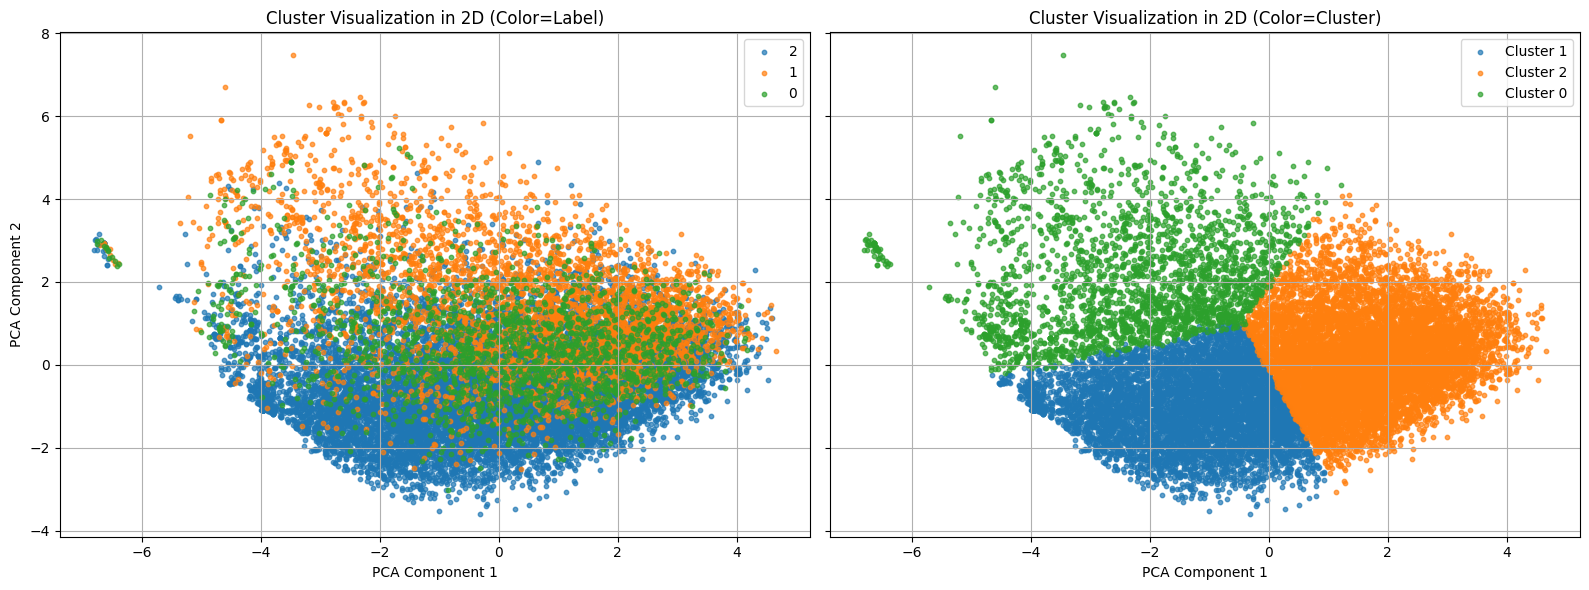

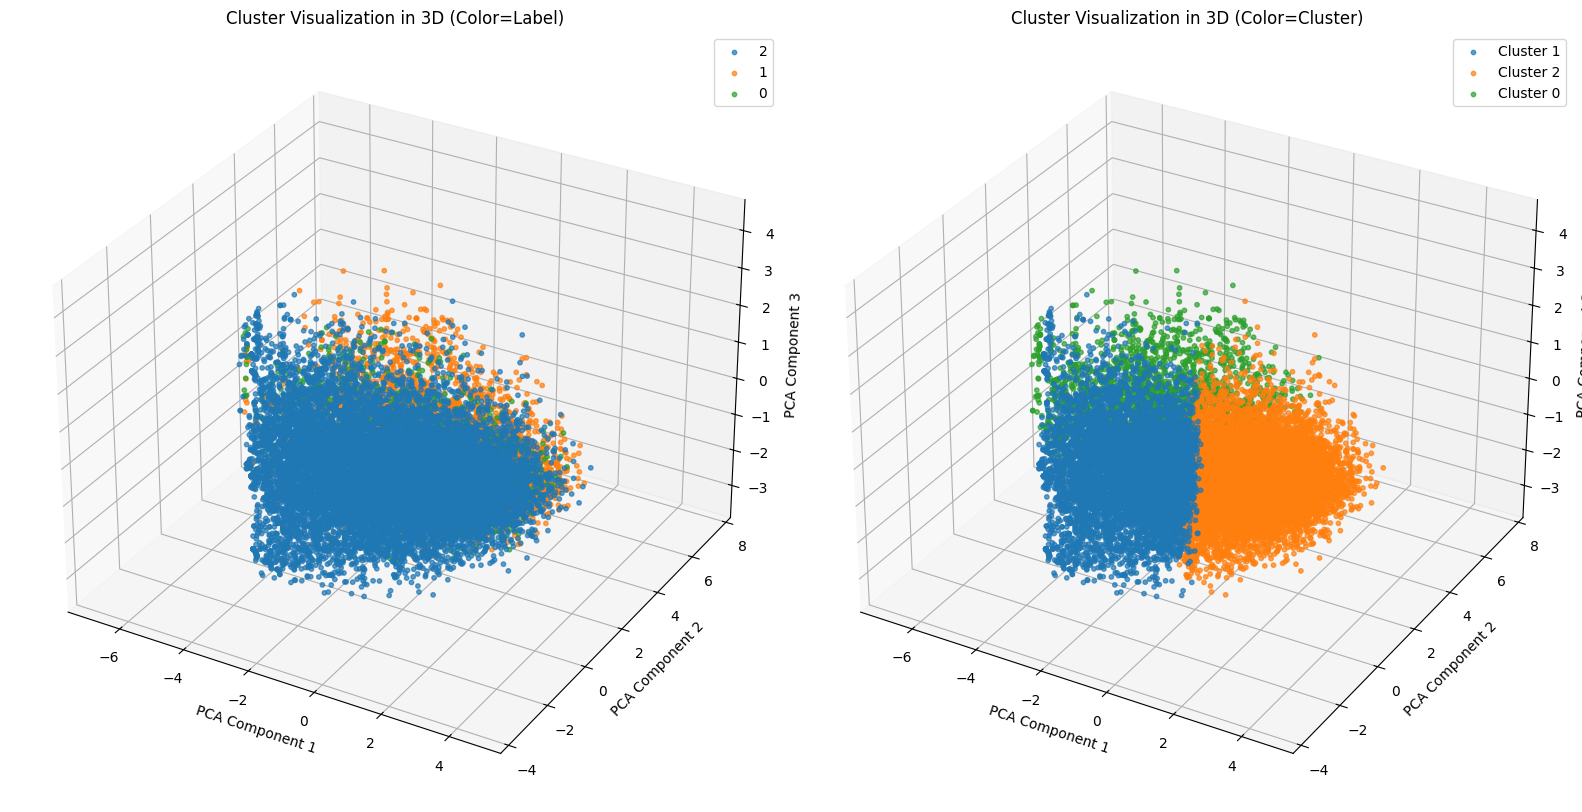


Purity Total: 0.70
Purity per Cluster:
 - Cluster 0: 0.47
 - Cluster 1: 0.88
 - Cluster 2: 0.62

F1-Score Total: 0.39
F1-Score per Cluster:
 - Cluster 0: 0.37
 - Cluster 1: 0.61
 - Cluster 2: 0.53


In [ ]:
# Convert mapped_sentiment to numeric
le = LabelEncoder()
y_true = df['mapped_sentiment']  # Label
y_true_numeric = le.fit_transform(y_true)
y_pred = df['cluster']  # Cluster

# EEvaluate clustering
results = evaluate_clustering(data_matrix, y_true_numeric, y_pred)

# CLUSTER SUM

In [ ]:
# Represent Data with SUM pooling of emotional features
data_matrix = create_data_matrix(embedding_dict, emotion_dict, synonyms_dict, df['document_tokens'], tfidf_matrix, feature_names, 'sum')
data_matrix.shape

(17672, 406)

In [ ]:
kmeans = KMeans(n_clusters=n_clusters, max_iter = 500, n_init = 100, random_state = 777)
df['cluster2'] = kmeans.fit_predict(data_matrix)

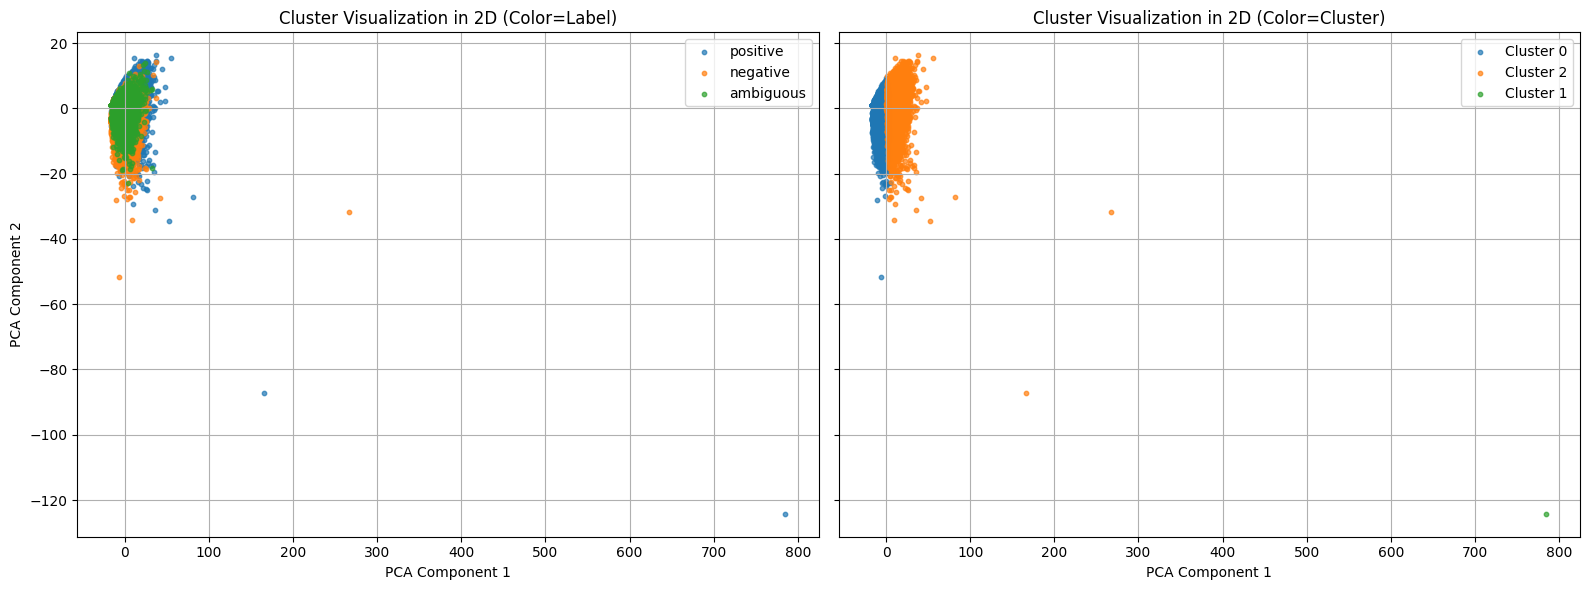

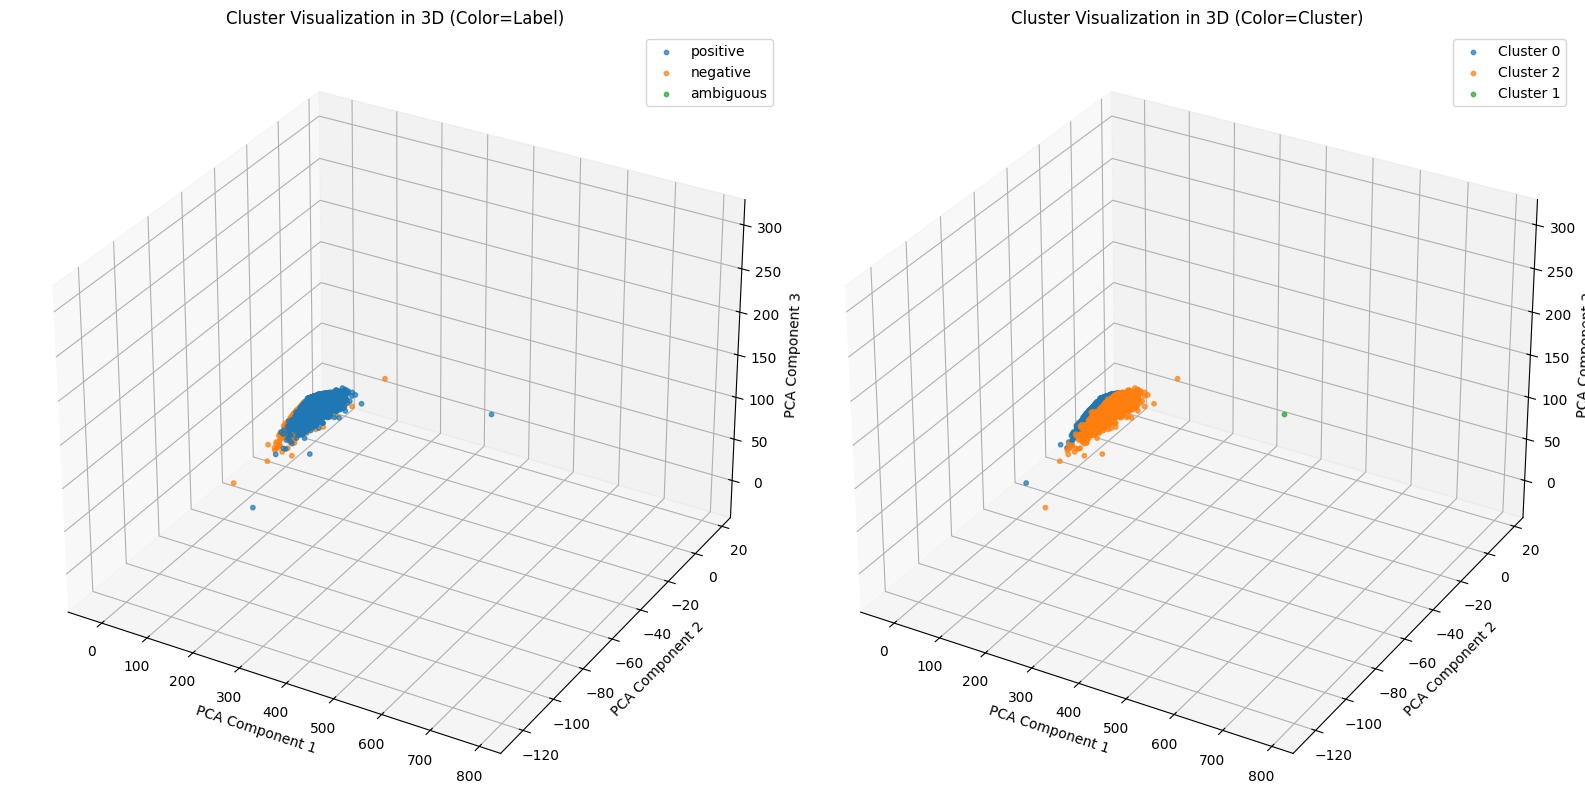


Purity Total: 0.68
Purity per Cluster:
 - Cluster 0: 0.65
 - Cluster 1: 1.00
 - Cluster 2: 0.74

F1-Score Total: 0.37
F1-Score per Cluster:
 - Cluster 0: 0.62
 - Cluster 1: 0.00
 - Cluster 2: 0.52


In [ ]:
y_pred = df['cluster2']
# Evaluate clustering
results = evaluate_clustering(data_matrix, y_true, y_pred)

# CLUSTER MEAN

In [ ]:
data_matrix = create_data_matrix(embedding_dict, emotion_dict, synonyms_dict, df['document_tokens'], tfidf_matrix, feature_names, 'mean')

In [ ]:
kmeans = KMeans(n_clusters=n_clusters, max_iter = 500, n_init = 100, random_state = 777)
df['cluster3'] = kmeans.fit_predict(data_matrix)

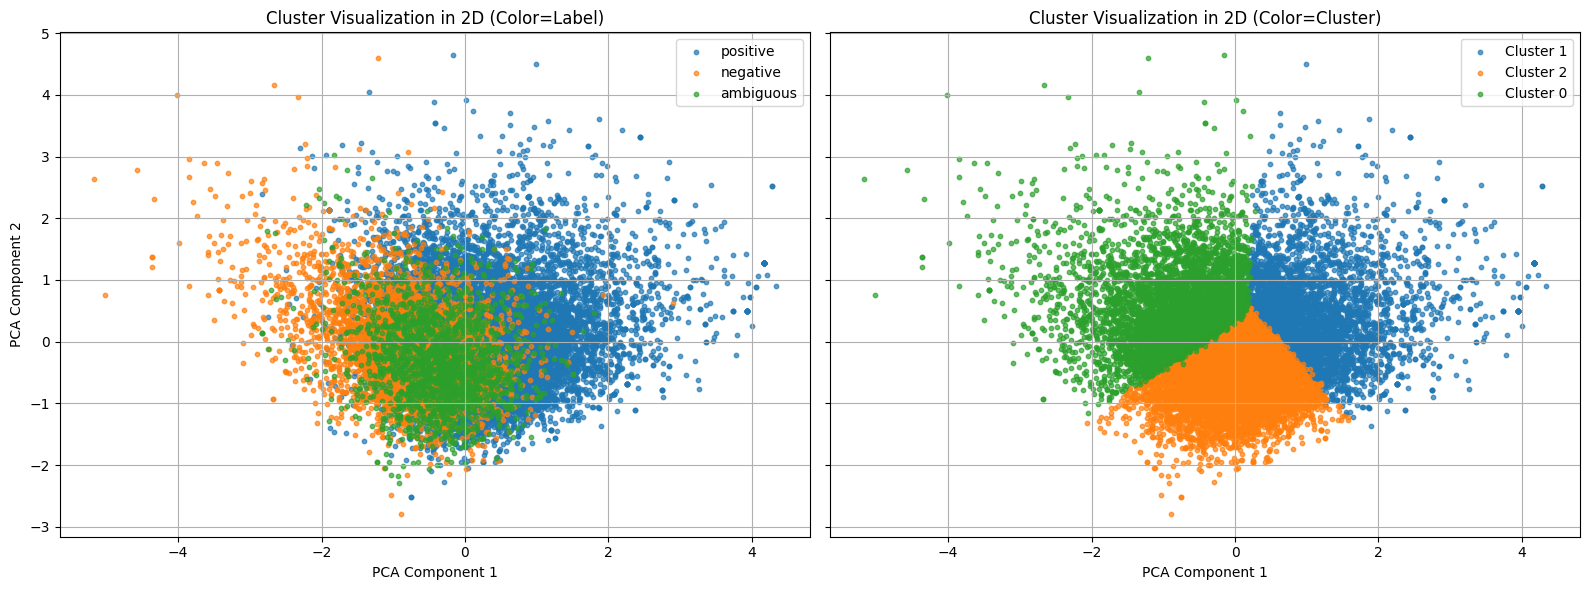

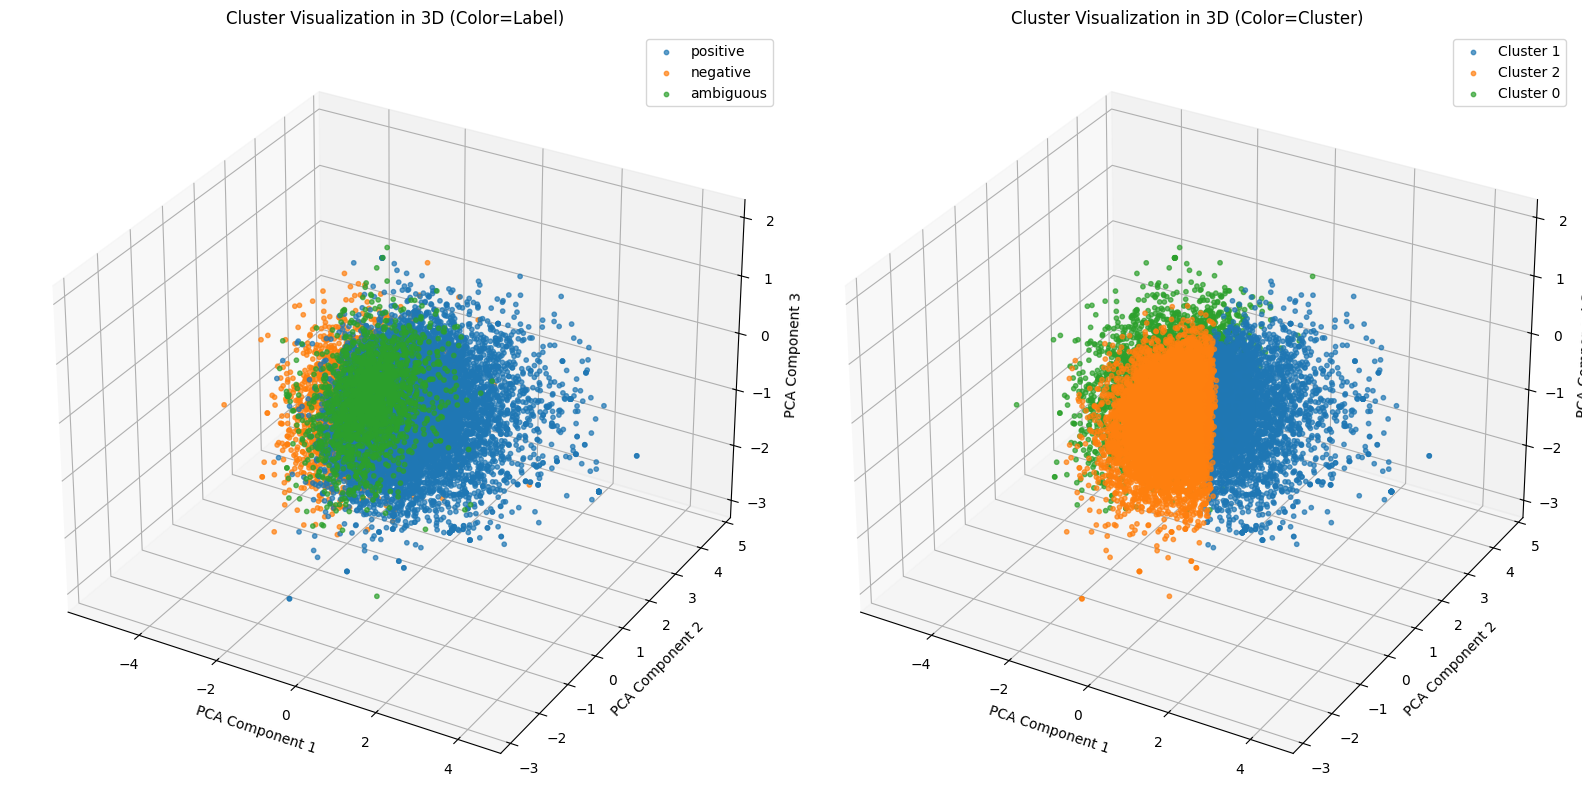


Purity Total: 0.68
Purity per Cluster:
 - Cluster 0: 0.49
 - Cluster 1: 0.96
 - Cluster 2: 0.67

F1-Score Total: 0.40
F1-Score per Cluster:
 - Cluster 0: 0.29
 - Cluster 1: 0.47
 - Cluster 2: 0.56


In [ ]:
y_pred = df['cluster3']
# Evaluate
results = evaluate_clustering(data_matrix, y_true, y_pred)

# ALTERNATIVE DISTANCES

In [ ]:
# Represent Data with MAX pooling of emotional features
data_matrix = create_data_matrix(embedding_dict, emotion_dict, synonyms_dict, df['document_tokens'], tfidf_matrix, feature_names, 'max')

In [ ]:
from sklearn.metrics.pairwise import cosine_distances
import numpy as np

# Funzione K-Means con Cosine Distance
def kmeans_cosine(data_matrix, n_clusters, max_iter=300, tol=1e-4):
    n_samples = data_matrix.shape[0]
    centroids = data_matrix[np.random.choice(n_samples, n_clusters, replace=False)]

    for _ in range(max_iter):
        distances = cosine_distances(data_matrix, centroids)
        labels = np.argmin(distances, axis=1)
        new_centroids = np.array([data_matrix[labels == i].mean(axis=0) for i in range(n_clusters)])

        if np.allclose(centroids, new_centroids, atol=tol):
            break
        centroids = new_centroids
    return labels

# Esegui clustering con distanza Cosine
df['cluster_cosine'] = kmeans_cosine(data_matrix, n_clusters=n_clusters)

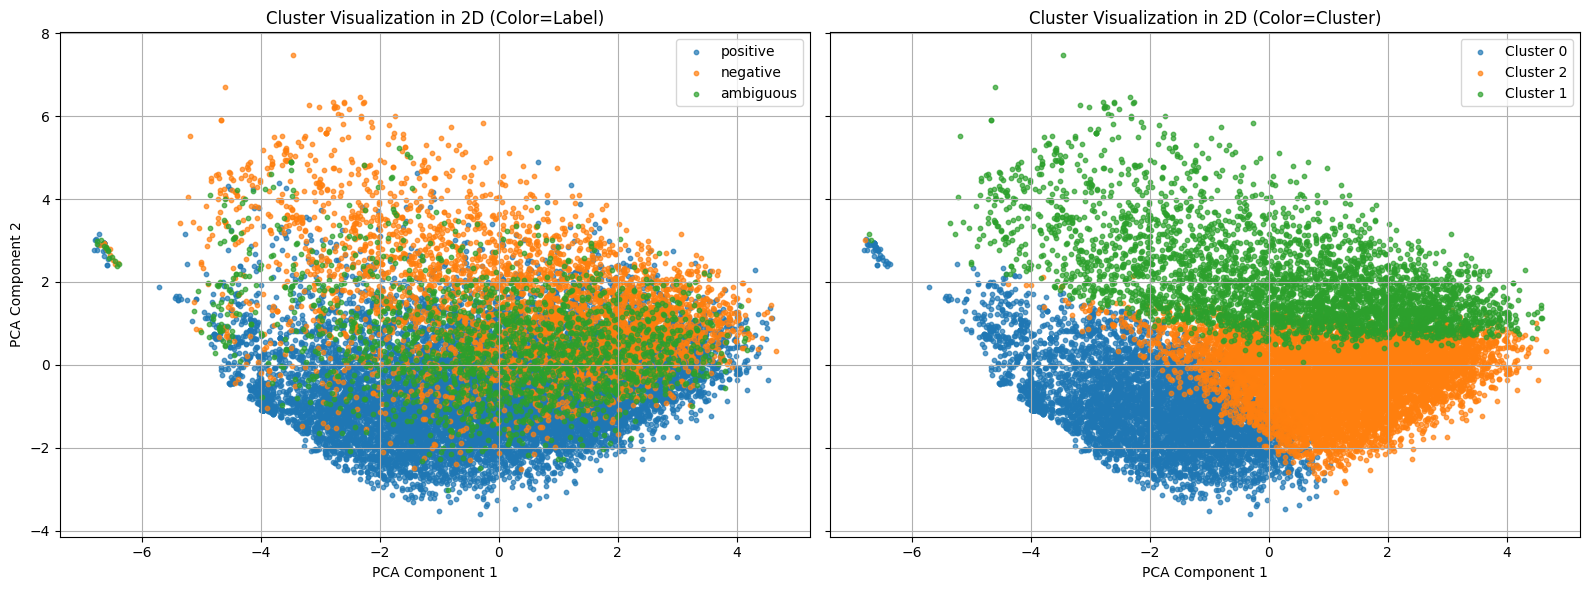

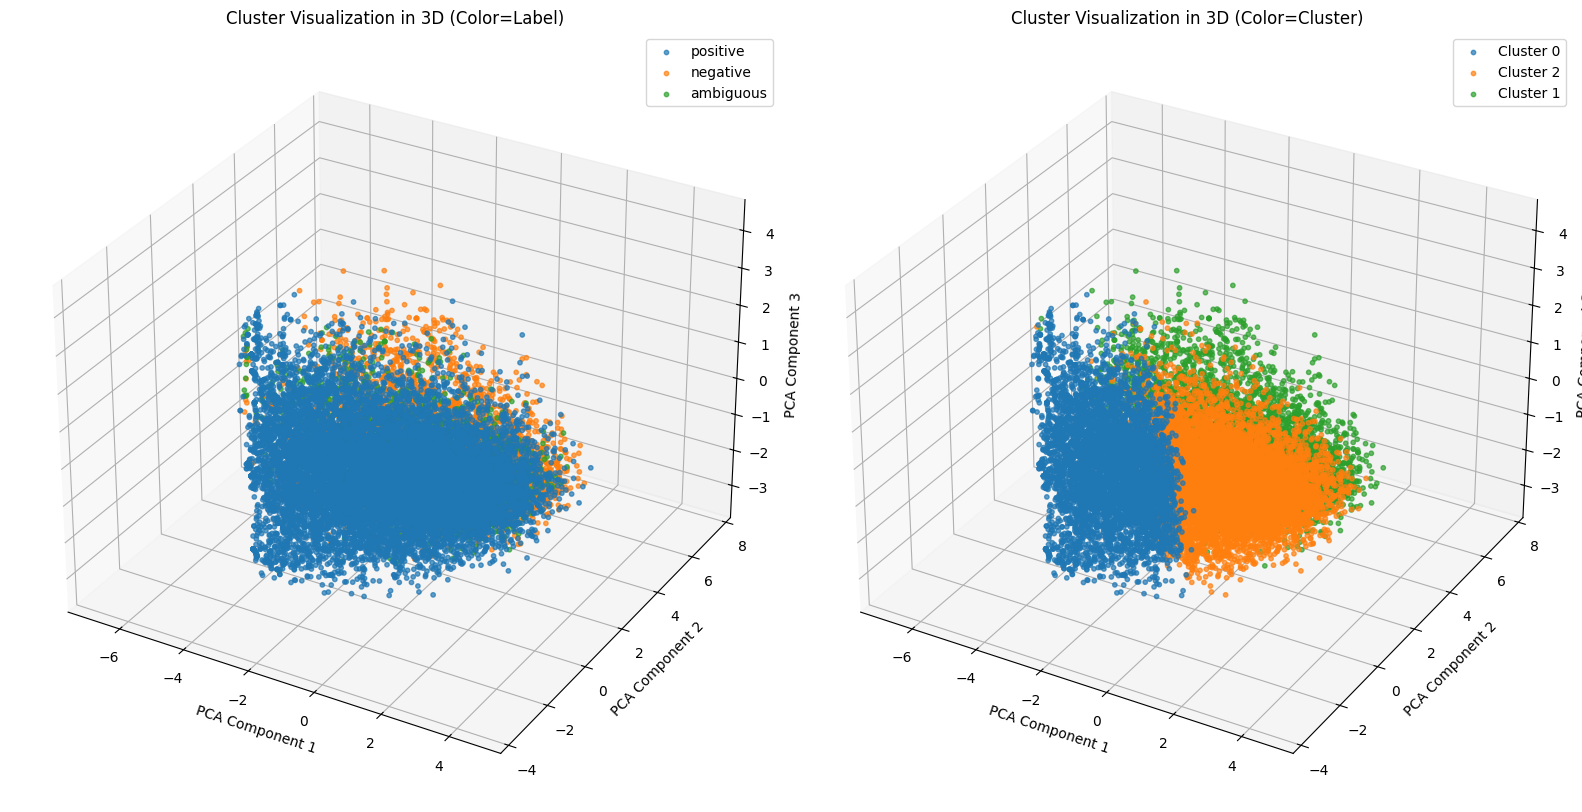


Purity Total: 0.75
Purity per Cluster:
 - Cluster 0: 0.89
 - Cluster 1: 0.59
 - Cluster 2: 0.73

F1-Score Total: 0.55
F1-Score per Cluster:
 - Cluster 0: 0.56
 - Cluster 1: 0.60
 - Cluster 2: 0.60


In [ ]:
y_pred = df['cluster_cosine']
results = evaluate_clustering(data_matrix, y_true, y_pred)

In [ ]:
# Clustering with K-Medoids (Manhattan/Cityblock Distance)
kmedoids_manhattan = KMedoids(n_clusters=3, metric='cityblock', random_state=777)
kmedoids_manhattan.fit(data_matrix)
df['cluster_manhattan'] = kmedoids_manhattan.labels_

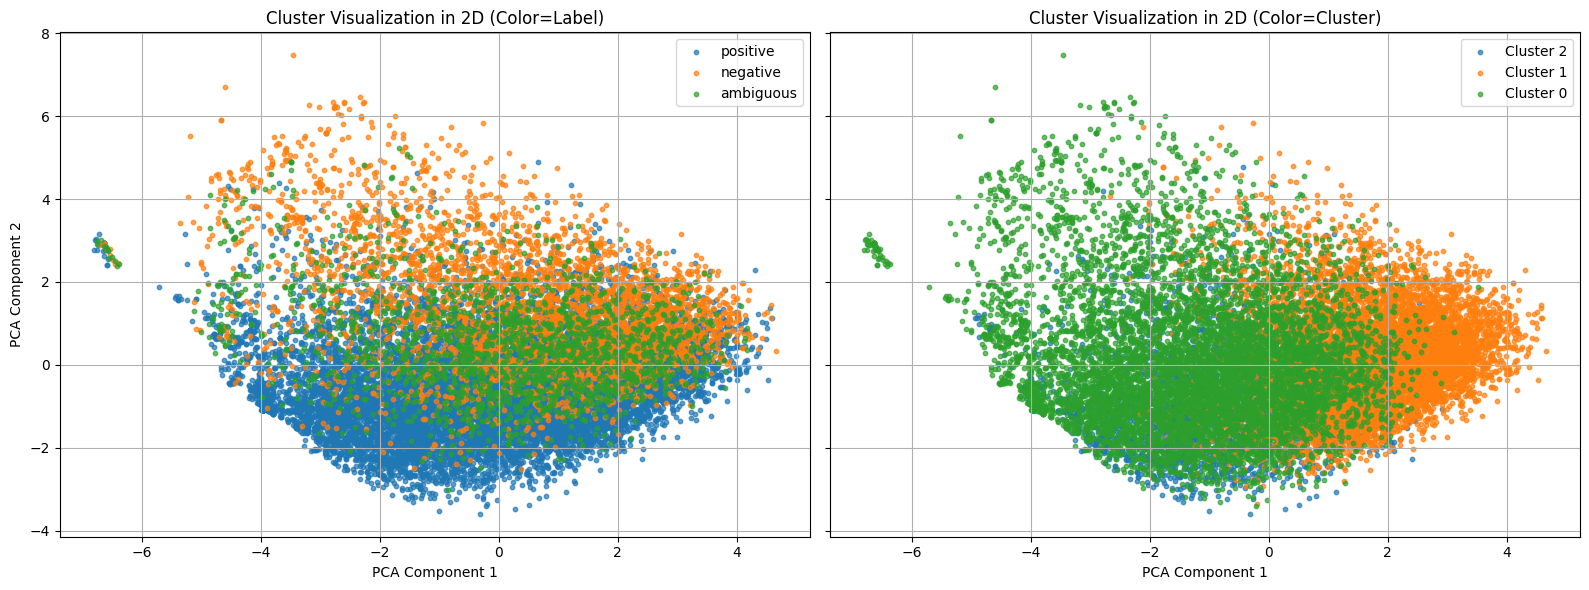

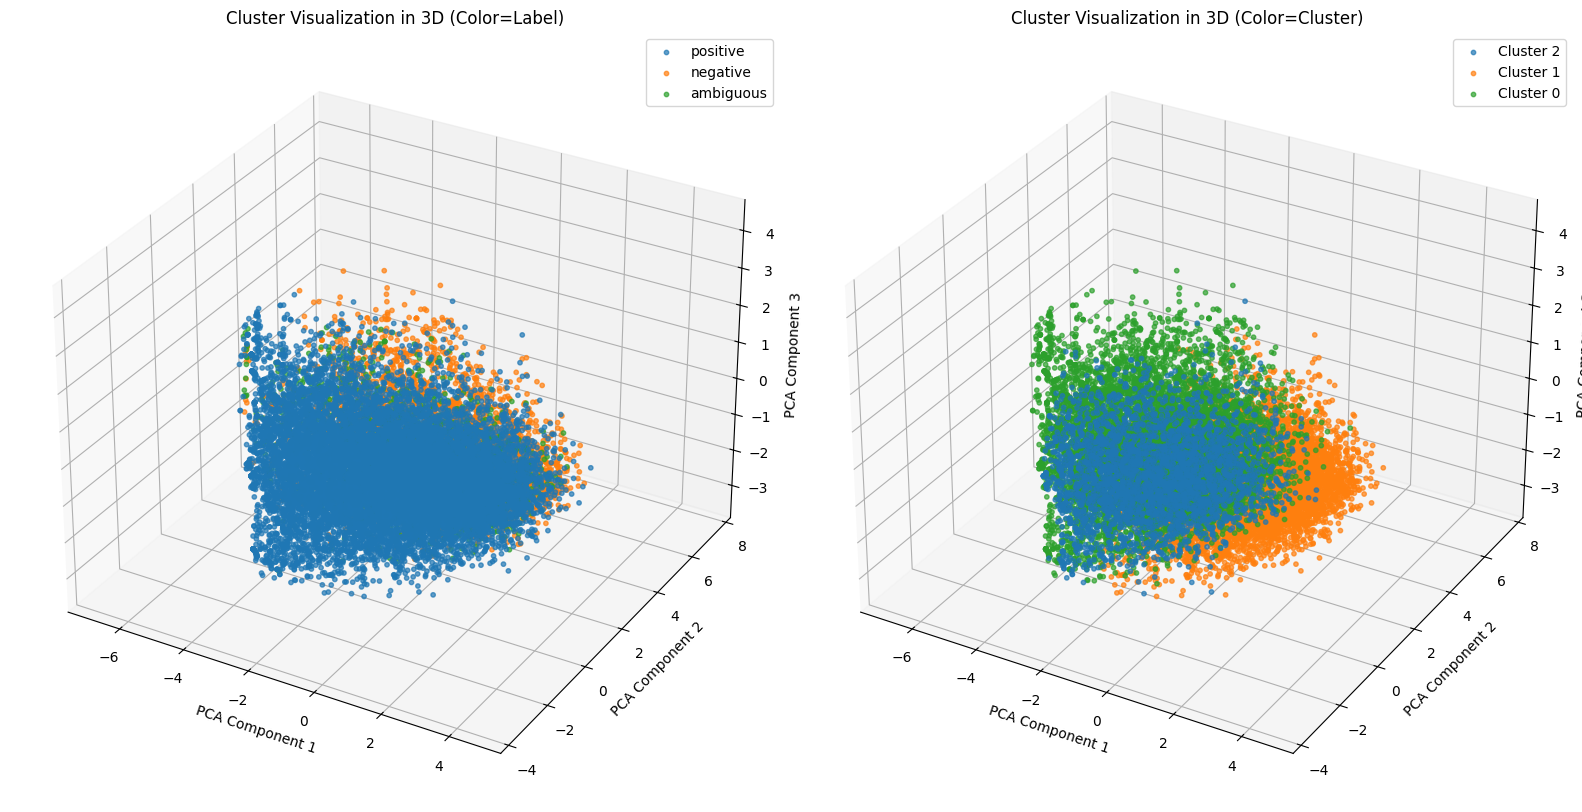


Purity Total: 0.68
Purity per Cluster:
 - Cluster 0: 0.68
 - Cluster 1: 0.62
 - Cluster 2: 0.82

F1-Score Total: 0.32
F1-Score per Cluster:
 - Cluster 0: 0.51
 - Cluster 1: 0.48
 - Cluster 2: 0.33


In [ ]:
y_pred = df['cluster_manhattan']
results = evaluate_clustering(data_matrix, y_true, y_pred)

In [ ]:
# Custom function K-Means with Mahalanobis Distance
def kmeans_mahalanobis(data_matrix, n_clusters, max_iter=300, tol=1e-4):
    n_samples, n_features = data_matrix.shape
    cov_matrix = np.cov(data_matrix, rowvar=False)
    inv_cov_matrix = inv(cov_matrix)
    centroids = data_matrix[np.random.choice(n_samples, n_clusters, replace=False)]

    for _ in range(max_iter):
        distances = np.array([
            [mahalanobis(x, c, inv_cov_matrix) for c in centroids] for x in data_matrix
        ])
        labels = np.argmin(distances, axis=1)
        new_centroids = np.array([data_matrix[labels == i].mean(axis=0) for i in range(n_clusters)])

        if np.allclose(centroids, new_centroids, atol=tol):
            break
        centroids = new_centroids
    return labels

df['cluster_mahalanobis'] = kmeans_mahalanobis(data_matrix, n_clusters=n_clusters)

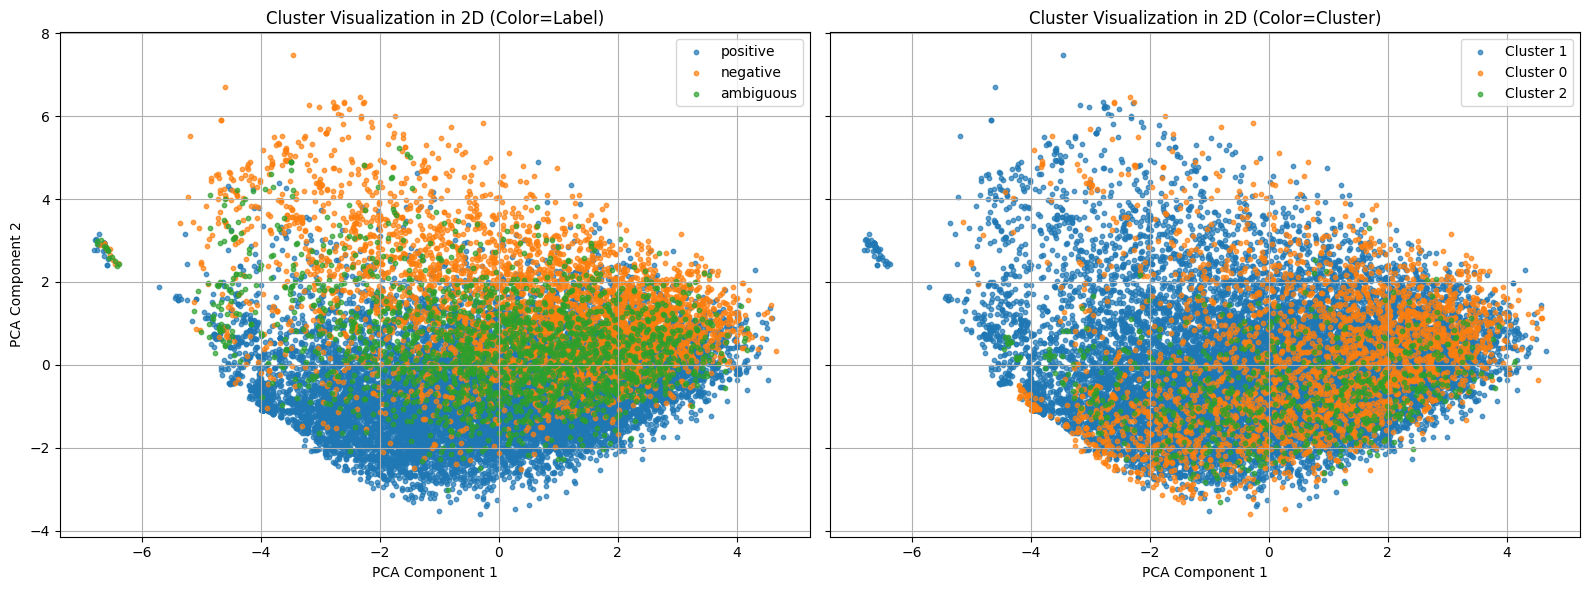

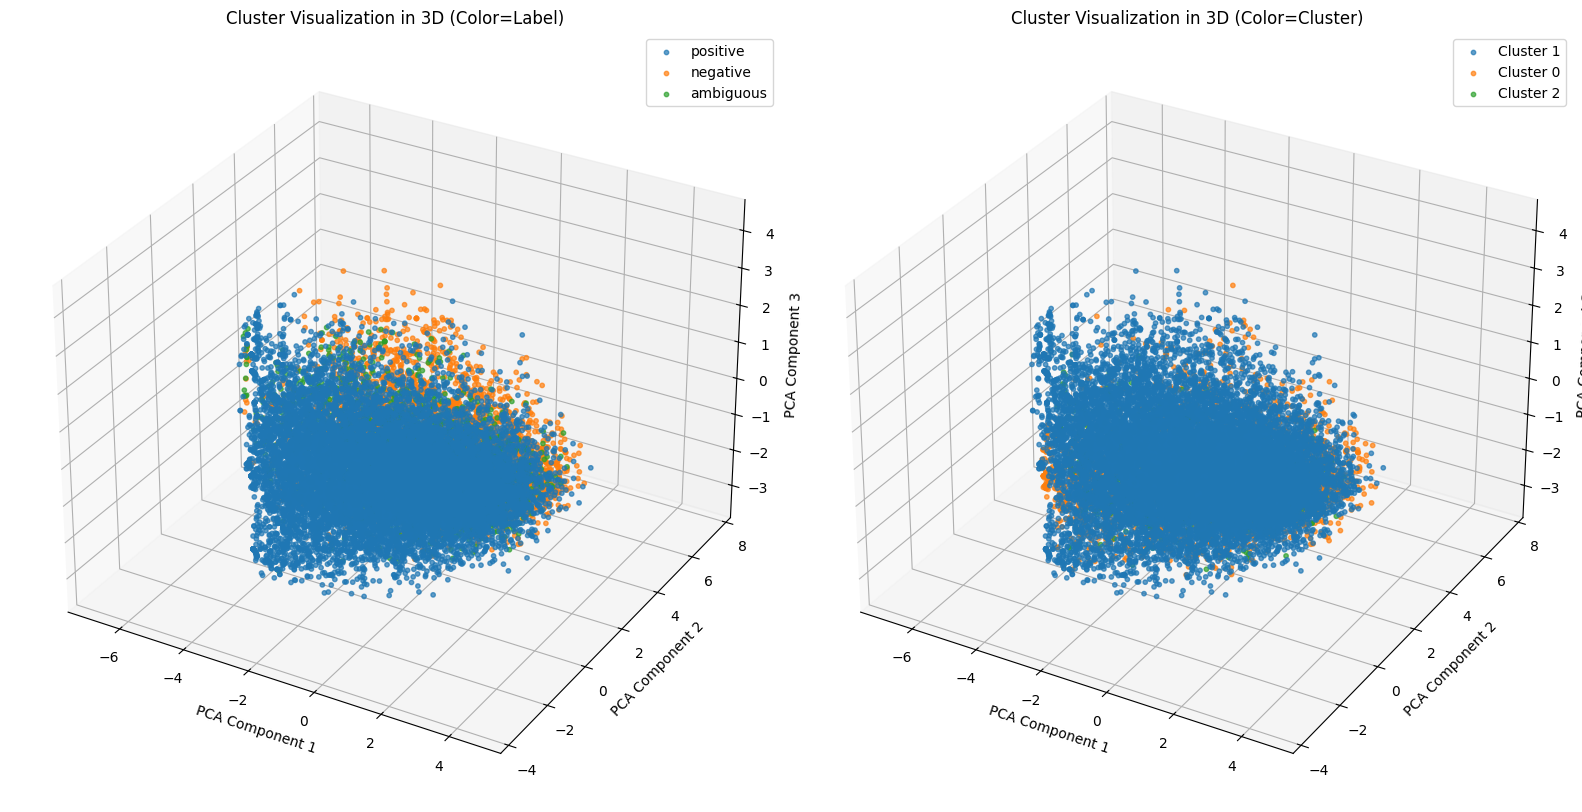


Purity Total: 0.68
Purity per Cluster:
 - Cluster 0: 0.66
 - Cluster 1: 0.67
 - Cluster 2: 0.95

F1-Score Total: 0.14
F1-Score per Cluster:
 - Cluster 0: 0.24
 - Cluster 1: 0.73
 - Cluster 2: 0.10


In [ ]:
y_pred = df['cluster_mahalanobis']
results = evaluate_clustering(data_matrix, y_true, y_pred)